# Unsupervised Learning

A big wholesale distributor wants to know how to best structure its delivery service to meet the needs of each customer. To do so, he wants to develop a methodology to efficiently sample two groups of customers for an A/B testing.
We will use a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure.
This dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this notebook, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
#import renders as rs
import matplotlib.pyplot as plt
from IPython.display import display # Allows the use of display() for DataFrames

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
We will now begin exploring the data through visualizations in order to understand how each feature is related to the others.

In [2]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In [3]:
from sklearn.cross_validation import train_test_split
from sklearn import tree

for dropped_feature in data.columns:


    # Make a copy of the DataFrame, using the 'drop' function to drop the given feature
    new_data = data.drop(dropped_feature, axis = 1)

    X = new_data
    y = data[dropped_feature]

    # Split the data into training and testing sets using the given feature as the target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # Create a decision tree regressor and fit it to the training set
    regressor = tree.DecisionTreeRegressor()
    regressor = regressor.fit(X_train,y_train)

    # Report the score of the prediction using the testing set
    score = regressor.score(X_test,y_test)

    print "Dropped feature: {}, regression score: {}".format(dropped_feature,score)

Dropped feature: Fresh, regression score: -0.511451306743
Dropped feature: Milk, regression score: 0.146747434397
Dropped feature: Grocery, regression score: 0.681885267471
Dropped feature: Frozen, regression score: -0.221263863265
Dropped feature: Detergents_Paper, regression score: 0.317993649433
Dropped feature: Delicassen, regression score: -2.95778622033


C:\Users\APonzio\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Is there any feature that could be dropped? Why?

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data.

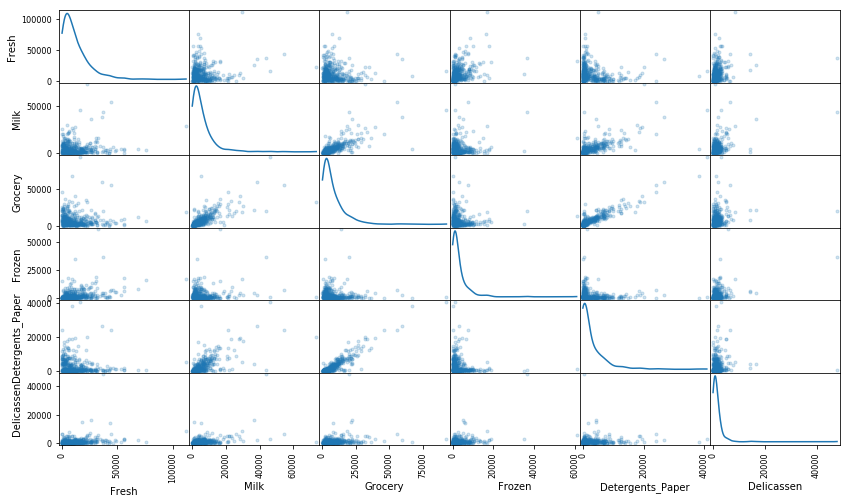

In [4]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.2, figsize = (14,8), diagonal = 'kde');

Are there any pairs of features which exhibit some degree of correlation? Does this confirm or deny our last statements?

## Data Preprocessing
In this section, we will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most often appropriate to apply a non-linear scaling — particularly for financial data. A simple approach which can work in most cases would be applying the natural logarithm. For a more complex approach one could rely on a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html)

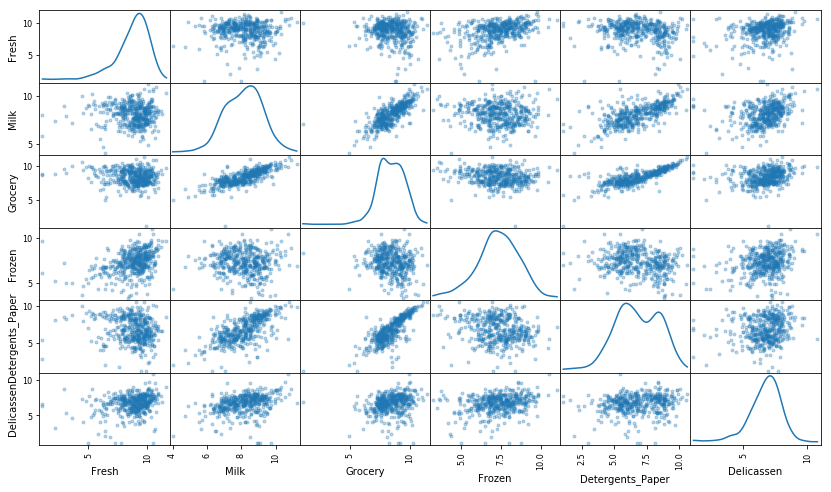

In [4]:
# Scale the data using the natural logarithm
log_data = data.apply(np.log)


# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use Tukey's Method for identfying outliers: an *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In [5]:
# For each feature find the data points with extreme high or low values

outliers_index_list = []

for feature in log_data.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature].values,25)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature].values,75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3-Q1)
    
    # Display the outliers
    print "Data points considered outliers for the feature '{}':".format(feature)
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    
    #create a list with outliers indexes#
    x = log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))].index.values.tolist()
    outliers_index_list += x

# create a Dataframe with outliers indexes and their molteplicity
outliers_index_list_no_dup = list(set(outliers_index_list))
count_list = [outliers_index_list.count(i) for i in outliers_index_list_no_dup]
outliers_df = pd.DataFrame({"Index":np.array(outliers_index_list_no_dup),"count":np.array(count_list)})

# Select the indices for data points to remove
#outliers = []
outliers  = outliers_df[outliers_df["count"] > 1.0]["Index"].values.tolist()
print "Outliers for more than one feature, ", outliers

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicassen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


Outliers for more than one feature,  [128L, 154L, 65L, 66L, 75L]


Are there any data points considered outliers for more than one feature? Should these data points be removed from the dataset?  

## Feature Transformation
In this section we will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA can also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. 

Explained variance of dimension 0 0.44302504749
Explained variance of dimension 1 0.263792183317
Explained variance of dimension 2 0.12306380111
Explained variance of dimension 3 0.101209078034
Explained variance of dimension 4 0.0485019638038
Explained variance of dimension 5 0.0204079262452


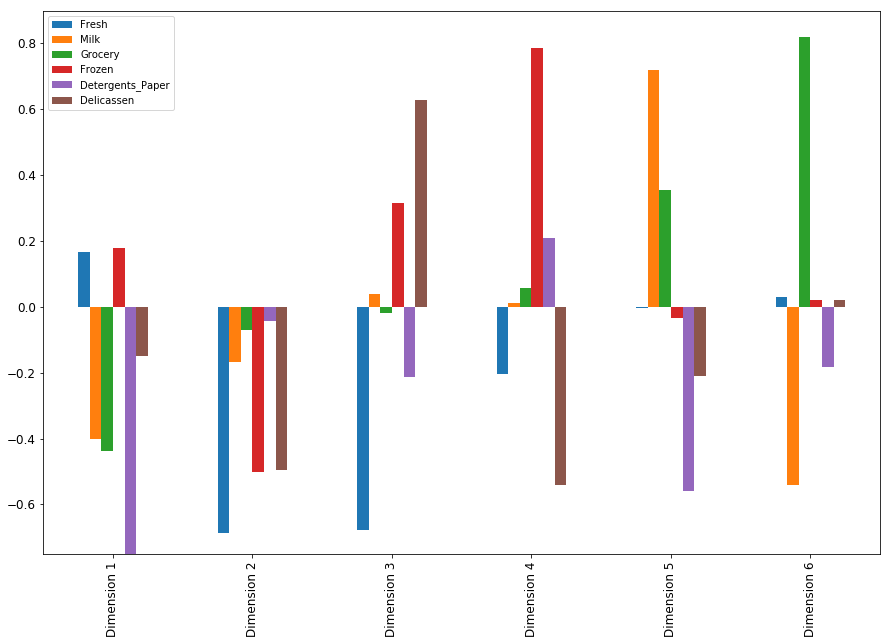

In [6]:
# Apply PCA to the good data with the same number of dimensions as features
from sklearn.decomposition import PCA

pca = PCA(n_components = len(good_data.keys())).fit(good_data)

#print pca.components_,pca.explained_variance_ratio_

for i in range(len(good_data.keys())):
    print "Explained variance of dimension {} {}".format(i,pca.explained_variance_ratio_[i])

df_weigths = pd.DataFrame(data = pca.components_,columns = good_data.keys())
df_weigths['Dimension'] = ["Dimension "+str(i+1) for i in range(len(df_weigths))]

ax = df_weigths[good_data.keys()].plot(kind='bar', figsize=(15, 10), legend=True, fontsize=12);
ax.set_xticklabels(df_weigths['Dimension'] );


# Generate PCA results plot
#pca_results = rs.pca_results(good_data, pca)

How much variance in the data is explained ***in total*** by the first and second principal component? 

### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards. In the following we will use only two dimensions.

In [7]:
# Fit PCA to the good data using only two dimensions
pca = PCA(n_components = 2).fit(good_data)

# Apply a PCA transformation the good data
reduced_data = pca.transform(good_data)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

## Clustering

In this section, we will use a K-Means clustering algorithm to identify the various customer segments hidden in the data.

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

best_pred = []
score_list = []
best_n_cluster = 0
best_clusterer = []

# Apply K-means to the reduced data 
for i in enumerate(range(2,7)):
    clusterer = KMeans(n_clusters = i[1])
    #clusterer = KMeans(n_clusters = i)
    clusterer = clusterer.fit(reduced_data)

    # Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # Find the cluster centers
    #centers = clusterer.cluster_centers_
    centers = clusterer.cluster_centers_

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data,preds)
    
    # Select the best clustering based on the silhouette score (there are many ways to do it..)
    
    if i[0] == 0:
        best_clusterer = clusterer
        score_list = [score]
    else:
        score_list.append(score)
        if score > max(score_list):
            best_clusterer = clusterer    

    print "Score obtained with {} clusters: {}".format(i[1],score)
print "\nBest score obtained with {} clusters: {}".format(len(best_clusterer.cluster_centers_),max(score_list))

Score obtained with 2 clusters: 0.426281015469
Score obtained with 3 clusters: 0.397138208845
Score obtained with 4 clusters: 0.331841276009
Score obtained with 5 clusters: 0.349997797526
Score obtained with 6 clusters: 0.365102790685

Best score obtained with 2 clusters: 0.426281015469


### Cluster Visualization
Once we've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, we are now ready to visualize the results.

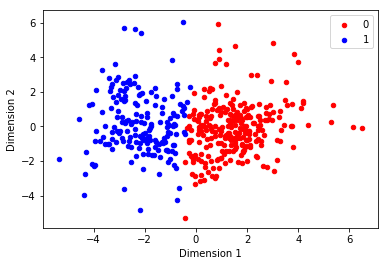

In [9]:
# Display the results of the clustering from implementation
reduced_data['cluster'] = best_clusterer.predict(reduced_data)
colors = {0:'red', 1:'blue'}

#reduced_data.plot.scatter(x = 'Dimension 1', y = 'Dimension 2',
#                          c = reduced_data['cluster'].apply(lambda x: colors[x]))

_, ax = plt.subplots()
for key,group in reduced_data.groupby('cluster'):
    group.plot.scatter(ax=ax, x='Dimension 1', y='Dimension 2', label=key, color = colors[key]);

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In [10]:
# Inverse transform the centers
centers = best_clusterer.cluster_centers_
log_centers = pca.inverse_transform(centers)

# Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Segment 0,8867.0,1897.0,2477.0,2088.0,294.0,681.0
Segment 1,4005.0,7900.0,12104.0,952.0,4561.0,1036.0


Companies often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services. If the wholesale distributor wanted to change its delivery service from 5 days a week to 3 days a week, how would you use the structure of the data to help them decide on a group of customers to test?

Assume the wholesale distributor wanted to predict some other feature for each customer based on the purchasing information available. How could the wholesale distributor use the structure of the data to assist a supervised learning analysis?